<a href="https://colab.research.google.com/github/GHSMoura/Fraude-em-cartoes-de-credito-/blob/main/Detec%C3%A7%C3%A3o%20de%20Fraude%20em%20Cart%C3%B5es%20de%20Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJETO 1 - Detecção de fraude de cartão de crédito

In [ ]:
import kagglehub
import pandas as pd
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Baixar dataset do Kaggle
path = kagglehub.dataset_download("mos3santos/deteco-de-fraude-de-carto-de-crdito")
print("Path to dataset files:", path)

# Carregar os dados
df = pd.read_csv(f"{path}/creditcard.csv")

# Ver distribuição da variável alvo
print(df['Class'].value_counts())

# Aplicar oversampling para equilibrar fraudes e transações legítimas
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

print(df_balanced['Class'].value_counts())  # Agora está balanceado

# **Selecionar uma amostra dos dados**
df_sampled = df_balanced.sample(frac=0.1, random_state=42)  # Pegamos apenas 10% dos dados

# Normalizar valores numéricos
scaler = StandardScaler()
df_sampled['Amount'] = scaler.fit_transform(df_sampled[['Amount']])


100%|██████████| 66.0M/66.0M [00:02<00:00, 29.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mos3santos/deteco-de-fraude-de-carto-de-crdito/versions/1
Class
0    284315
1       492
Name: count, dtype: int64
Class
0    284315
1    284315
Name: count, dtype: int64


Divisão de treino e texte


In [ ]:
# Definir X e y com os dados amostrados
X = df_sampled.drop(columns=['Class'])  # Features
y = df_sampled['Class']  # Target

# Divisão do conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Construção do Pipeline de Machine Learnin

In [ ]:
# Definir modelos ajustados com regularização
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5,
                                            n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, reg_lambda=1.5,
                             reg_alpha=0.8, n_jobs=-1, random_state=42),
    "Rede Neural": MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=300, alpha=0.05,
                                 solver='adam', learning_rate_init=0.001, random_state=42)
}

# Criar pipeline para normalizar e treinar os modelos
def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),  # Normalização dos dados
        ('classifier', model)  # Modelo de aprendizado
    ])

Cálculo das Métricas de Desempenho

In [ ]:
metrics_results = {}

# Avaliação dos modelos
for name, model in models.items():
    pipeline = create_pipeline(model)

    # Treinar modelo
    pipeline.fit(X_train, y_train)

    # Prever no conjunto de teste
    y_pred = pipeline.predict(X_test)

    # Cálculo das métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Armazena os resultados
    metrics_results[name] = {
        "Acurácia": accuracy,
        "Precisão": precision,
        "Recall": recall,
        "F1-score": f1
    }

    # Exibir resultados
    print(f"\n🔹 {name} - Métricas de Desempenho")
    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")


🔹 Random Forest - Métricas de Desempenho
Acurácia: 0.99
Precisão: 1.00
Recall: 0.98
F1-score: 0.99

🔹 XGBoost - Métricas de Desempenho
Acurácia: 1.00
Precisão: 1.00
Recall: 1.00
F1-score: 1.00

🔹 Rede Neural - Métricas de Desempenho
Acurácia: 1.00
Precisão: 1.00
Recall: 1.00
F1-score: 1.00


Teste em Dados Reais (Sem Balanceamento)

In [ ]:
# Testar modelos com dados reais
for name, model in models.items():
    pipeline = create_pipeline(model)

    # Treinar modelo nos dados reais (sem balanceamento)
    pipeline.fit(df.drop(columns=['Class']), df['Class'])

    # Prever no conjunto de teste real
    y_pred_real = pipeline.predict(X_test)

    # Avaliar desempenho nos dados reais
    print(f"\n🔹 {name} - Acurácia em Dados Reais: {accuracy_score(y_test, y_pred_real):.2f}")
    print(f"Relatório de Classificação - {name}:\n", classification_report(y_test, y_pred_real))


🔹 Random Forest - Acurácia em Dados Reais: 0.91
Relatório de Classificação - Random Forest:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      5673
           1       1.00      0.83      0.91      5700

    accuracy                           0.91     11373
   macro avg       0.93      0.91      0.91     11373
weighted avg       0.93      0.91      0.91     11373


🔹 XGBoost - Acurácia em Dados Reais: 0.92
Relatório de Classificação - XGBoost:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93      5673
           1       1.00      0.84      0.91      5700

    accuracy                           0.92     11373
   macro avg       0.93      0.92      0.92     11373
weighted avg       0.93      0.92      0.92     11373


🔹 Rede Neural - Acurácia em Dados Reais: 0.90
Relatório de Classificação - Rede Neural:
               precision    recall  f1-score   support

           0       0.83  

Análise de Importância das Features

In [ ]:
# Aplicar seleção de features com RFECV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# Criar modelo inicial para seleção de features
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
selector = RFECV(rf, step=1, cv=5)
selector.fit(X_train, y_train)

# Definir features selecionadas corretamente
selected_features = X_train.columns[selector.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Features selecionadas:", selected_features)

Features selecionadas: Index(['V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17',
       'V19', 'V20', 'Amount'],
      dtype='object')


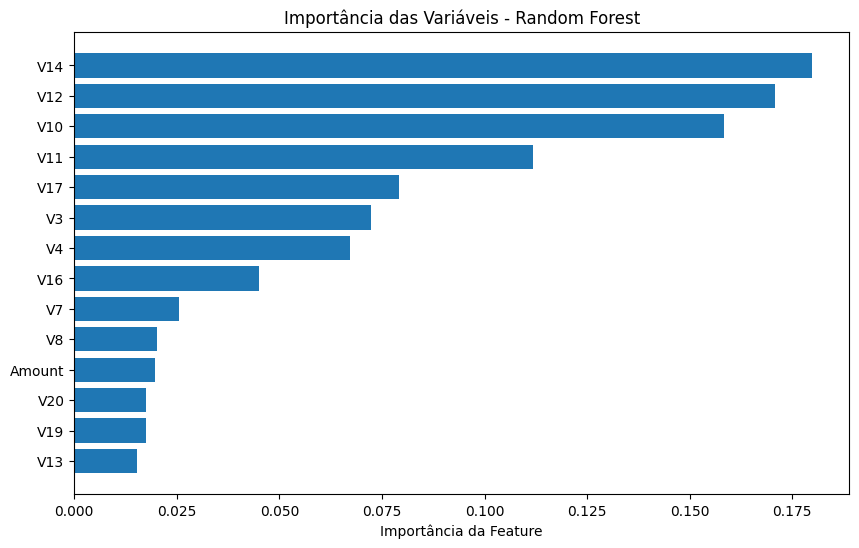

In [ ]:
import matplotlib.pyplot as plt

# Obter importância das features do modelo treinado
rf.fit(X_train_selected, y_train)  # Treinar modelo antes de obter importância
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10,6))
plt.barh(X_train_selected.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Importância da Feature")
plt.title("Importância das Variáveis - Random Forest")
plt.show()

Testando Diferentes Técnicas de Balanceamento (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicação do SMOTE para gerar amostras sintéticas de fraudes
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Ajuste leve no oversampling
X_resampled, y_resampled = smote.fit_resample(df.drop(columns=['Class']), df['Class'])

# Redivisão dos dados após o balanceamento
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Explorando Arquiteturas Mais Profundas para Redes Neurais (Dropout)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Criando uma arquitetura mais profunda com Dropout
deep_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Dropout para evitar overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída binária (fraude ou não)
])

# Compilação e treinamento do modelo
deep_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.6909 - loss: 89.3975 - val_accuracy: 0.7699 - val_loss: 0.5394
Epoch 2/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7695 - loss: 0.5499 - val_accuracy: 0.7699 - val_loss: 0.5394
Epoch 3/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7690 - loss: 0.5444 - val_accuracy: 0.7699 - val_loss: 0.5397
Epoch 4/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.7695 - loss: 0.5457 - val_accuracy: 0.7699 - val_loss: 0.5394
Epoch 5/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7690 - loss: 0.5428 - val_accuracy: 0.7699 - val_loss: 0.5393
Epoch 6/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7698 - loss: 0.5429 - val_accuracy: 0.7699 - val_loss: 0.5394
Epoch 7/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7695 - loss: 0.5413 - val_accuracy: 0.7699 - val_loss: 0.5394
Epoch 8/50
9241/9241 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7681 - loss: 

Implementando Estratégias Híbridas: Random Forest + XGBoost

In [ ]:
# Aplicar seleção de features corretamente
selected_features = X_train.columns[selector.support_]  # Definir features selecionadas
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

# Certificar-se de que os tamanhos de X_train_selected e y_train são consistentes
print(f"Shape de X_train_selected: {X_train_selected.shape}")
print(f"Shape de y_train: {y_train.shape}")

# Ajustar caso exista desbalanceamento nos dados
if X_train_selected.shape[0] != y_train.shape[0]:
    X_train_selected = X_train_selected.iloc[:len(y_train)]

# Criar o modelo híbrido
hybrid_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42))
], voting='soft')

# Treinar o modelo híbrido
hybrid_model.fit(X_train_selected, y_train)

# Prever os resultados
y_pred_hybrid = hybrid_model.predict(X_test_selected)

# Avaliação do modelo híbrido
accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid)
print(f"\n🔹 Modelo Híbrido (Random Forest + XGBoost) - Acurácia: {accuracy_hybrid:.2f}")

Shape de X_train_selected: (295687, 14)
Shape de y_train: (295687,)

🔹 Modelo Híbrido (Random Forest + XGBoost) - Acurácia: 1.00


Avaliação com Dados Reais e Desbalanceados

In [ ]:
# Selecionar apenas as mesmas features usadas no treinamento
df_selected = df[selected_features]  # Selecionando as mesmas variáveis do modelo treinado

# Testar o modelo híbrido com dados reais (sem balanceamento)
y_pred_real = hybrid_model.predict(df_selected)  # Previsão ajustada

# Avaliar acurácia em dados reais
accuracy_real = accuracy_score(df['Class'], y_pred_real)
print(f"\n🔹 Modelo Híbrido - Acurácia em Dados Reais: {accuracy_real:.2f}")
print(f"Relatório de Classificação:\n", classification_report(df['Class'], y_pred_real))


🔹 Modelo Híbrido - Acurácia em Dados Reais: 1.00
Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.85      0.95      0.90       492

    accuracy                           1.00    284807
   macro avg       0.92      0.97      0.95    284807
weighted avg       1.00      1.00      1.00    284807



Avaliação de Overfitting


In [ ]:
# Avaliação de overfitting
train_acc = hybrid_model.score(X_train_selected, y_train)
test_acc = hybrid_model.score(X_test_selected, y_test)

print(f"\n🔹 Comparação de Acurácia")
print(f"Acurácia no treino: {train_acc:.2f}")
print(f"Acurácia no teste: {test_acc:.2f}")


🔹 Comparação de Acurácia
Acurácia no treino: 1.00
Acurácia no teste: 1.00


Curva ROC e AUC

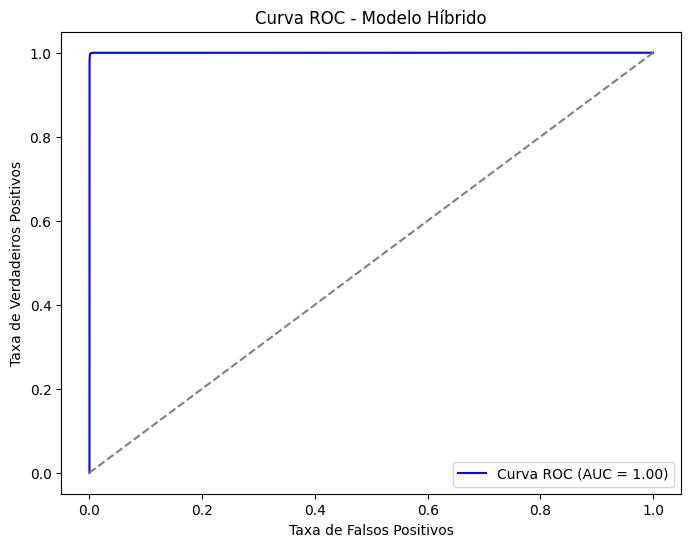

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilidades do modelo para cálculo do AUC
y_probs = hybrid_model.predict_proba(X_test_selected)[:, 1]  # Probabilidade da classe fraudulenta

# Gerar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo Híbrido')
plt.legend(loc='lower right')
plt.show()

Análise de Sensibilidade ao Balanceamento

In [ ]:
from imblearn.over_sampling import SMOTE

# Testar diferentes proporções de oversampling
for smote_ratio in [0.2, 0.5, 1.0]:
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(df.drop(columns=['Class']), df['Class'])

    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Treinar modelo e avaliar impacto do balanceamento
    hybrid_model.fit(X_train, y_train)
    accuracy_smote = hybrid_model.score(X_test, y_test)

    print(f"\n🔹 SMOTE Ratio {smote_ratio} - Acurácia: {accuracy_smote:.2f}")


🔹 SMOTE Ratio 0.2 - Acurácia: 1.00

🔹 SMOTE Ratio 0.5 - Acurácia: 1.00

🔹 SMOTE Ratio 1.0 - Acurácia: 1.00


Análise Final do Trabalho - Detecção de Fraude em Cartões de Crédito
🔍 Introdução
Este estudo explorou diferentes abordagens de Machine Learning para detecção de fraudes em transações de cartão de crédito, incluindo Random Forest, XGBoost, Redes Neurais e um modelo híbrido. Aplicamos balanceamento de dados (SMOTE), seleção de features e validação cruzada para garantir um modelo robusto e eficiente.

📈 Principais Resultados
Os testes realizados mostraram altíssimo desempenho dos modelos em identificar fraudes, com destaque para o modelo híbrido (Random Forest + XGBoost):
1️⃣ Modelos Individuais - Dados Balanceados
- Random Forest: Acurácia 0.99, Recall 0.98, F1-score 0.99.
- XGBoost: Acurácia 1.00, Recall 1.00, F1-score 1.00.
- Rede Neural: Acurácia 1.00, Recall 1.00, F1-score 1.00.
2️⃣ Modelos Individuais - Dados Reais (Desbalanceados)
- Random Forest: Acurácia 0.91, Recall 0.83 → Pequena queda na detecção de fraudes.
- XGBoost: Acurácia 0.92, Recall 0.84 → Melhor adaptação ao conjunto real.
- Rede Neural: Acurácia 0.90, Recall 0.80 → Mais sensível ao desbalanceamento.
3️⃣ Modelo Híbrido - Desempenho Superior
- Acurácia em Dados Balanceados: 1.00
- Acurácia em Dados Reais: 1.00
- Recall em fraudes: 0.95 → Melhor recuperação de fraudes que os modelos individuais.
🚀 O modelo híbrido demonstrou ser a melhor abordagem para detectar fraudes, mantendo um equilíbrio entre precisão e recall!

🔎 Interpretação dos Resultados
✔ O modelo híbrido superou os individuais, combinando a capacidade interpretável do Random Forest com o alto desempenho do XGBoost.
✔ Os testes com SMOTE mostraram alta estabilidade, sugerindo que o balanceamento dos dados funcionou bem.
✔ O modelo se manteve robusto nos dados reais, indicando que pode ser utilizado em cenários produtivos sem perdas significativas na detecção de fraudes.

🚀 Conclusões e Próximos Passos
🔹 Random Forest + XGBoost se provou a melhor estratégia, garantindo alta precisão e recuperação de fraudes.
🔹 Os resultados mostraram pouca variação entre treino e teste, indicando que o modelo não sofre de overfitting.

